In [1]:
import gc
import json
import os
import pickle as pk
import random
import re
import shutil
import time
from collections import Counter

import cv2
import easyocr
import matplotlib.pyplot as plt
import numpy as np
import PIL
import pytesseract
import requests
import torch
from IPython.display import HTML
from matplotlib import animation
from matplotlib.animation import FuncAnimation
from transformers import (
    AutoModel,
    AutoModelForCausalLM,
    AutoModelForSeq2SeqLM,
    AutoTokenizer,
    pipeline,
)
from vidaug import augmentors as va

In [2]:
NUM_FRAMES = 5
IMAGE_SIZE = (224, 224)


def copy_random_videos(source_folder, destination_folder):
    """
    Copies a random video from each subfolder within the source folder to the destination folder.

    Args:
        source_folder (str): Path to the folder containing the subfolders.
        destination_folder (str): Path to the destination folder where videos will be copied.
    """

    if not os.path.exists(destination_folder):
        os.makedirs(destination_folder)

    subfolders = [f.path for f in os.scandir(source_folder) if f.is_dir()]

    for subfolder in subfolders:
        video_files = [
            f.path
            for f in os.scandir(subfolder)
            if f.is_file() and f.name.lower().endswith((".mp4", ".avi", ".mov", ".mkv"))
        ]  # add more video extensions as needed.

        if video_files:
            random_video = random.choice(video_files)
            video_name = os.path.basename(random_video)
            destination_path = os.path.join(destination_folder, video_name)
            shutil.copy2(random_video, destination_path)
            print(
                f"Copied {video_name} from {os.path.basename(subfolder)} to {destination_folder}"
            )
        else:
            print(f"No video files found in {os.path.basename(subfolder)}")


def get_all_videos(source_folder):
    """
    Recursively finds all video files (.mp4, .avi, .mov, .mkv) within a source folder and its subfolders,
    returning a list of their real paths.
    """
    res = []
    for root, _, files in os.walk(source_folder):
        for file in files:
            if file.lower().endswith((".mp4", ".avi", ".mov", ".mkv")):
                full_path = os.path.join(root, file)
                res.append(
                    os.path.realpath(full_path)
                )  # Use realpath to get the canonical path

    return res


def test_random_video_processor(video_path: str) -> np.ndarray:
    frames = []
    cap = cv2.VideoCapture(video_path)

    # Get total number of frames
    total_frames = int(cap.get(cv2.CAP_PROP_FRAME_COUNT))

    if total_frames <= 0:
        raise ValueError("Could not read frames from video file")

    # Generate 5 unique random frame indices
    frame_indices = sorted(
        random.sample(range(total_frames), min(total_frames, NUM_FRAMES))
    )

    for frame_idx in frame_indices:
        # Set frame position
        cap.set(cv2.CAP_PROP_POS_FRAMES, frame_idx)

        # Read frame
        ret, frame = cap.read()
        if ret:
            # Convert BGR to RGB
            frame_rgb = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
            frame_rgb = cv2.resize(frame_rgb, IMAGE_SIZE)

            frames.append(frame_rgb)

    # Release video capture object
    cap.release()

    while len(frames) < NUM_FRAMES:
        if frames:  # if there is any frame append the last one.
            frames.append(frames[-1])
        else:  # if there is no frame, create a black image
            black_image = np.zeros((IMAGE_SIZE[0], IMAGE_SIZE[1], 3), dtype=np.uint8)
            frames.append(black_image)

    video_data = np.stack(frames) / 255
    return video_data.astype(np.float32)


def display_video_numpy(video_data):
    """
    Displays a NumPy array representing video data in a Jupyter Notebook.

    Args:
        video_data (numpy.ndarray): A NumPy array representing video data.
                                    Expected shape: (frames, height, width, channels) or (frames, height, width)
    """
    if video_data.ndim == 3:  # Grayscale video
        frames, height, width = video_data.shape
        channels = 1
    elif video_data.ndim == 4:  # Color video
        frames, height, width, channels = video_data.shape
    else:
        raise ValueError("Video data must be a 3D or 4D NumPy array.")

    fig, ax = plt.subplots()
    if channels == 1:
        im = ax.imshow(video_data[0], cmap="gray", animated=True)
    else:
        im = ax.imshow(video_data[0], animated=True)

    def update(frame):
        if channels == 1:
            im.set_array(video_data[frame])
        else:
            im.set_array(video_data[frame])
        return (im,)

    ani = FuncAnimation(
        fig, update, frames=frames, interval=200, blit=True
    )  # Adjust interval for playback speed
    plt.close()  # Prevents showing the static first frame

    return HTML(ani.to_html5_video())

In [3]:
videos = get_all_videos("/d/hmdb51_org")

In [4]:
v = random.choice(videos)

In [5]:
processed_v = test_random_video_processor(v)
display_video_numpy(processed_v)

In [7]:
with open("../training/data/data_sampled_w_duplications_shuffled.pkl", "rb") as f:
    X_data, Y_data = pk.load(f)

X_data.shape, len(videos)

((77325,), 6766)

In [15]:
len(np.unique(videos))

6766

In [20]:
X = []
Y = []
for x in np.unique(X_data):
    X.append(x)
    Y.append(1)

for x in np.unique(videos):
    X.extend([x] )
    Y.extend([0])

# non_meme_size = len(videos)*10
# X.extend(random.choices(videos, k=non_meme_size))
# Y.extend([0]*non_meme_size)

X = np.array(X)
Y = np.array(Y, dtype=np.int8)

X.shape, Y.shape

((27134,), (27134,))

(array([ 6766.,     0.,     0.,     0.,     0.,     0.,     0.,     0.,
            0., 20368.]),
 array([0. , 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1. ]),
 <BarContainer object of 10 artists>)

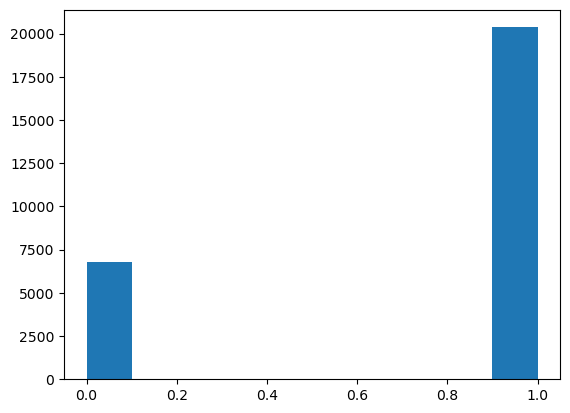

In [21]:
plt.hist(Y)

In [23]:
combined = np.column_stack((X, Y))

# Shuffle the combined array
np.random.shuffle(combined)

# Separate the arrays back into X and Y
X_shuffled = combined[:, 0].astype(X.dtype)  # Retain original dtype
Y_shuffled = combined[:, 1].astype(Y.dtype)

print("Shuffled X:", X_shuffled)
print("Shuffled Y:", Y_shuffled)

Shuffled X: ['/d/hmdb51_org/sit/American_History_X_sit_f_cm_np1_le_med_27.avi'
 '/d/hmdb51_org/run/RETURN_OF_THE_KING_run_f_cm_np1_fr_med_31.avi'
 '/home/lehoangchibach/Documents/Code/gif_analytics/templates/template_examples/c77b85a126f44745c1f93be21e14fe2f_440607250.gif'
 ...
 '/home/lehoangchibach/Documents/Code/gif_analytics/templates/template_examples/5fc7a6172cc39c610faa02ebc2a37ee2_377716924.gif'
 '/home/lehoangchibach/Documents/Code/gif_analytics/templates/template_data/-memetemplate-368620167-neo-fight.mp4'
 '/d/hmdb51_org/swing_baseball/BaseballHitinSlowMotion_swing_baseball_f_nm_np1_le_bad_1.avi']
Shuffled Y: [0 0 1 ... 1 1 0]


In [28]:
idxes = np.random.choice(range(X_shuffled.shape[0]), size=10)
for i in idxes:
    print(Y_shuffled[i], X_shuffled[i])

0 /d/hmdb51_org/drink/AmericanGangster_drink_h_nm_np1_fr_goo_53.avi
1 /home/lehoangchibach/Documents/Code/gif_analytics/templates/template_examples/4724986fb22049ded15439adac4f68ed_182188649.gif
0 /d/hmdb51_org/shoot_gun/Italian_Job_1_shoot_gun_u_cm_np1_fr_med_4.avi
1 /home/lehoangchibach/Documents/Code/gif_analytics/templates/template_examples/3f8446db6b3702930f680b4dd0b3be89_300800483.gif
1 /home/lehoangchibach/Documents/Code/gif_analytics/templates/template_examples/fa2e6b070d655f8a610f52250f84dde2_265070425.gif
1 /home/lehoangchibach/Documents/Code/gif_analytics/templates/template_examples/8bd92e0774d9d2f45a0962ca300935f6_350827103.gif
1 /home/lehoangchibach/Documents/Code/gif_analytics/templates/template_examples/4d7c103034560cba3eb916fb0d0b8189_451829692.gif
1 /home/lehoangchibach/Documents/Code/gif_analytics/templates/template_data/-memetemplate-487519743-Tommy-Tuberville-Falling-Down-Plane-Stairs.mp4
1 /home/lehoangchibach/Documents/Code/gif_analytics/templates/template_example

In [29]:
data = [X_shuffled, Y_shuffled]
with open("./outputs/meme_unique_vs_nonmeme_unique_dataset.pkl", "wb") as f:
    pk.dump(data, f)